In [3]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
from enlib import enmap, lensing as enlensing
import numpy as np
from orphics import maps,io,stats,cosmology,lensing
from szar import counts

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
theory_file_root = "../../alhazen/data/Aug6_highAcc_CDM"
cc = counts.ClusterCosmology(skipCls=True)
theory = cosmology.loadTheorySpectraFromCAMB(theory_file_root,unlensedEqualsLensed=False,useTotal=False,TCMB = 2.7255e6,lpad=9000,get_dimensionless=False)

# Cluster params
mass = 2e14
conc = 3.0
overdensity = 200
critical = True
atclusterz = True
z = 0.7

#mass = 2e14
#conc = 3.2
#overdensity = 180
#critical = False
#atclusterz = False
#z = 0.7


# Experiment

noise = 10.0
beam = 1.0

# Template
width_arcmin = 15.
px_res_arcmin = 0.5
shape,wcs = maps.rect_geometry(width_arcmin=width_arcmin,px_res_arcmin=px_res_arcmin)
modrmap = enmap.modrmap(shape,wcs)
modlmap = enmap.modlmap(shape,wcs)



# N
kbeam = maps.gauss_beam(beam,modlmap)

def get_ncov(inoise):
    noise_uK_rad = inoise*np.pi/180./60.
    normfact = np.sqrt(np.prod(enmap.pixsize(shape,wcs)))
    noise_uK_pixel = noise_uK_rad/normfact
    return np.diag([(noise_uK_pixel)**2.]*np.prod(shape))
Ncov = get_ncov(noise)
n2d = (noise*np.pi/180./60.)**2.+modlmap*0.
ngen = maps.MapGen(shape,wcs,n2d.reshape((1,1,shape[0],shape[1])))

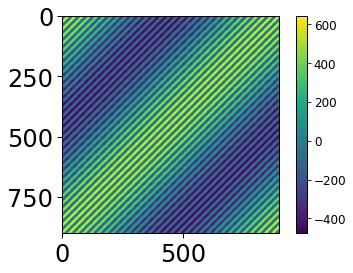

In [95]:
power2d = theory.uCl('TT',modlmap)
bfcov = maps.diagonal_cov(power2d)
ny,nx = shape                     
Ucov = maps.pixcov(shape,wcs,bfcov)
Ucov = enmap.enmap(Ucov.reshape(np.prod(shape),np.prod(shape)),wcs)
io.plot_img(Ucov)
mgen = maps.MapGen(shape,wcs,power2d.reshape((1,1,shape[0],shape[1])))

In [77]:
print(Ucov.shape)

(900, 900)


In [78]:
def lcov(imass):
    lens_order = 5                    
    posmap = enmap.posmap(shape,wcs)
    
    # kappa
    kappa = lensing.nfw_kappa(imass,modrmap,cc,overdensity=overdensity,critical=critical,atClusterZ=atclusterz,zL=z)

    
    phi,_ = lensing.kappa_to_phi(kappa,modlmap,return_fphi=True)
    grad_phi = enmap.grad(phi)    
    pos = posmap + grad_phi      
    alpha_pix = enmap.sky2pix(shape,wcs,pos, safe=False) 
    scov = lensing.lens_cov(Ucov,alpha_pix,lens_order=lens_order,kbeam=kbeam,bshape=shape)  
    return scov

In [79]:
scov = lcov(mass)

In [80]:
step = mass*0.1
scov_up = lcov(mass+step/2.)
scov_dn = lcov(mass-step/2.)
dcov = (scov_up-scov_dn)/step


1022939560000.0
316.8553879274919


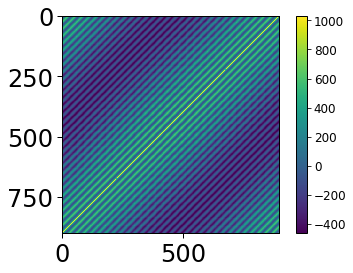

316.8553879274919


In [81]:
print(np.linalg.cond( scov ))
print(np.linalg.cond( scov + Ncov))
tcov = scov + Ncov
io.plot_img(tcov)
print(np.linalg.cond( tcov))


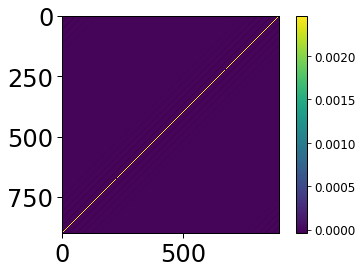

In [70]:
from scipy.linalg import pinv2                                                                                                                       
s,logdet = np.linalg.slogdet(tcov)
cinv = pinv2(tcov)

io.plot_img(cinv)


In [82]:
dcov_dict= {}
dcov_dict['mass'] = dcov
fid_params_dict = {}
fid_params_dict['mass'] = mass
tcov = scov + Ncov
foqe = stats.OQE(tcov,dcov_dict,fid_params_dict,invert=False,deproject=True)

[3.42503472e+14]


In [83]:
merr = foqe.sigma()['mass']
N = 1000
msn = mass/merr*np.sqrt(N)
print(msn)

18.465667751565952


In [84]:
sns = []
noises = [10.,7.,5.,3.,1.,0.5,0.1]
for noise in noises:
    print(noise)
    Ncov = get_ncov(noise)    
    tcov = scov + Ncov #+ 5000
    foqe = stats.OQE(tcov,dcov_dict,fid_params_dict)
    sns.append(mass/foqe.sigma()['mass']*np.sqrt(1000.))


10.0
[3.42503472e+14]
7.0
[2.6777715e+14]
5.0
[2.11553885e+14]
3.0
[1.45604533e+14]
1.0
[6.5497135e+13]
0.5
[3.95123683e+13]
0.1
[1.25023075e+13]


[ 18.46566775  23.6187267   29.89571818  43.43652754  96.56232022
 160.06520469 505.87104061]


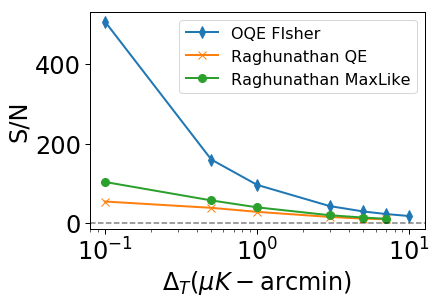

In [139]:
qesn = \
[54.90901676,
39.07056506,
29.01941776,
16.23952687,
11.90733869,
10.54165923]

mlsn = \
[103.8990549,
57.66774171,
40.32114719,
20.54065028,
14.66201689,
11.73662547]

pl = io.Plotter(xscale="log",ylabel="S/N",xlabel="$\\Delta_T (\\mu K-\\mathrm{arcmin})$")
sns = np.array(sns)
print(sns)
pl.add(noises,sns,marker="d",label="OQE FIsher",lw=2,markersize=8)
pl.add(noises[1:],qesn[::-1],marker="x",label="Raghunathan QE",lw=2,markersize=8)
pl.add(noises[1:],mlsn[::-1],marker="o",label="Raghunathan MaxLike",lw=2,markersize=8)
pl.hline()
pl.legend(loc='upper right',labsize=16)
pl.done()

In [172]:
noise = 0.1

n2d = (noise*np.pi/180./60.)**2.+modlmap*0.
ngen = maps.MapGen(shape,wcs,n2d.reshape((1,1,shape[0],shape[1])))

Ncov = get_ncov(noise)
tcov = scov + Ncov
foqe = stats.OQE(tcov,dcov_dict,fid_params_dict,invert=False,deproject=True)

mass = 2.2e14
lens_order = 5
posmap = enmap.posmap(shape,wcs)
kappa = lensing.nfw_kappa(mass,modrmap,cc,overdensity=overdensity,critical=critical,atClusterZ=atclusterz,zL=z)
phi,_ = lensing.kappa_to_phi(kappa,modlmap,return_fphi=True)
grad_phi = enmap.grad(phi)    
pos = posmap + grad_phi
alpha_pix = enmap.sky2pix(shape,wcs,pos, safe=False) 


N = 1000
merrs = []
for i in range(N):
    if (i+1)%100==0: print(i+1)
    unlensed = mgen.get_map()      
    noise_map = ngen.get_map()      
    lensed = maps.filter_map(enlensing.displace_map(unlensed, alpha_pix, order=lens_order),kbeam)
    obs = lensed + noise_map
    
    dat = obs.ravel()
    dat -= dat.mean()
    merrs.append(foqe.estimate(dat)['mass'])

100
200
300
400
500
600
700
800
900
1000


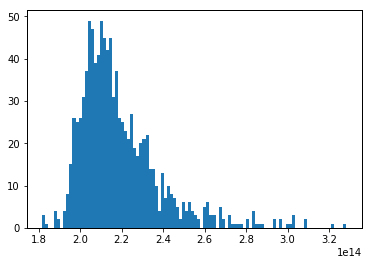

2.190358615391888
2.13947347560281
1.8156380118889812
345.8216872444116


In [173]:
from scipy.stats import mode
merrs = np.array(merrs)
#io.plot_img(obs)
io.hist(merrs,bins=100)
print(merrs.mean()/1e14)
print(np.median(merrs)/1e14)
mv,cts = mode(merrs)
print(mv[0]/1e14)


print(merrs.mean()/merrs.std()*np.sqrt(1000.))